# Imports & DB Connection

In [36]:
import pandas as pd
import psycopg2
import os
from psycopg2.extras import execute_values
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud

# Connecting to bank_reviews database

In [37]:
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user= os.getenv("DB_USER"),
    password=os.getenv("DB_PASS"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
query =  """
SELECT r.review_id, r.bank_id, b.bank_name, r.review_text, r.rating,
       r.review_date, r.sentiment_label, r.sentiment_score, r.source
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id;
"""
data = pd.read_sql(query,conn)
data.tail()

C:\Users\PC\AppData\Local\Temp\ipykernel_10016\3913539638.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query,conn)


,review_id,bank_id,bank_name,review_text,rating,review_date,sentiment_label,sentiment_score,source
1446,1451,3,Bank of Abyssinia,the underrated app I've ever seen and ur banki...,1,2024-06-27,Neutral,0.0000,Google Play Store
1447,1452,3,Bank of Abyssinia,It demands to disable developer option.,1,2024-06-27,Neutral,0.0000,Google Play Store
1448,1453,3,Bank of Abyssinia,"It's been two months now, I cannot do any tran...",1,2024-06-26,Neutral,-0.4125,Google Play Store
1449,1454,3,Bank of Abyssinia,Open Open service,5,2024-06-26,Neutral,0.0000,Google Play Store
1450,1455,3,Bank of Abyssinia,NaN,1,2024-06-25,Neutral,0.0000,Google Play Store


# Insights

## Drivers(Positive Features) per Bank

In [38]:
drivers_keywords = {
    "fast": ["fast", "quick", "smooth"],
    "easy": ["easy", "simple", "user friendly"],
    "good_service": ["helpful", "support", "responsive"]
}


## Pain Points (negative keywords)

In [39]:
pain_keywords = {
    "crash": ["crash", "freeze", "stuck", "not opening"],
    "login": ["login", "password", "session", "authentication"],
    "slow": ["slow", "laggy", "takes time"]
}


# Extract Drivers per Bank

In [40]:
results_drivers = {}
def count_keywords(row,keywords):
    return any(k in row for k in keywords)
def extract_result_per_bank(all_keywords):
    for bank in data['bank_name'].unique():
        bank_data = data[data['bank_name']==bank]
        bank_results = {}
        for label,keywords, in all_keywords.items():
            bank_results[label] = bank_data['review_text'].str.lower().apply(lambda x: count_keywords(x,keywords)).sum()

        results_drivers[bank] = bank_results
    return results_drivers
drivers_results = extract_result_per_bank(drivers_keywords)
drivers_results

{'Commercial Bank of Ethiopia': {'fast': np.int64(10),
  'easy': np.int64(23),
  'good_service': np.int64(4)},
 'Dashen Bank': {'fast': np.int64(73),
  'easy': np.int64(61),
  'good_service': np.int64(9)},
 'Bank of Abyssinia': {'fast': np.int64(19),
  'easy': np.int64(15),
  'good_service': np.int64(3)}}

# Extract Pain per Bank

In [41]:
pain_results = extract_result_per_bank(pain_keywords)
pain_results

{'Commercial Bank of Ethiopia': {'crash': np.int64(2),
  'login': np.int64(7),
  'slow': np.int64(1)},
 'Dashen Bank': {'crash': np.int64(5),
  'login': np.int64(5),
  'slow': np.int64(20)},
 'Bank of Abyssinia': {'crash': np.int64(27),
  'login': np.int64(10),
  'slow': np.int64(18)}}

## Suggestions per Bank (Automatically Generated)

In [42]:
suggestions = {}
for bank in data['bank_name'].unique():
    pain = pain_results[bank]
    improvement_list = []
    if pain.get('crash',0)>=10:
        improvement_list.append("Improve app stability and crash reporting.")
    if pain.get("login", 0) >=10:
        improvement_list.append("Enhance login reliability and reduce authentication errors.")
    if pain.get("slow", 0) >=10:
        improvement_list.append("Optimize backend services to improve speed.")
    suggestions[bank] = improvement_list
suggestions

{'Commercial Bank of Ethiopia': [],
 'Dashen Bank': ['Optimize backend services to improve speed.'],
 'Bank of Abyssinia': ['Improve app stability and crash reporting.',
  'Enhance login reliability and reduce authentication errors.',
  'Optimize backend services to improve speed.']}

# Compare Banks

In [43]:
comparsion = data.groupby(['bank_name', 'sentiment_label']).size().unstack(fill_value=0)
comparsion

sentiment_label,Negative,Neutral,Positive
bank_name,,,
Bank of Abyssinia,31,379,70
Commercial Bank of Ethiopia,10,329,137
Dashen Bank,13,350,132


# Compare Banks based on the final_result's themes

In [44]:
final_df = pd.read_csv('../data/processed/reviews_final.csv')
comparsion = final_df.groupby(['bank_name', ])['themes'].value_counts()
comparsion

bank_name                    themes                                                                                       
Bank of Abyssinia            Other                                                                                            274
                             User Interface & Experience                                                                      142
                             Transaction Performance                                                                           11
                             Transaction Performance, User Interface & Experience                                              11
                             Account Access Issues, User Interface & Experience                                                 8
                             User Interface & Experience, Feature Requests                                                      8
                             Feature Requests                                                    

# Visualization

## 1. Sentiment Distribution per Bank (Bar Plot)

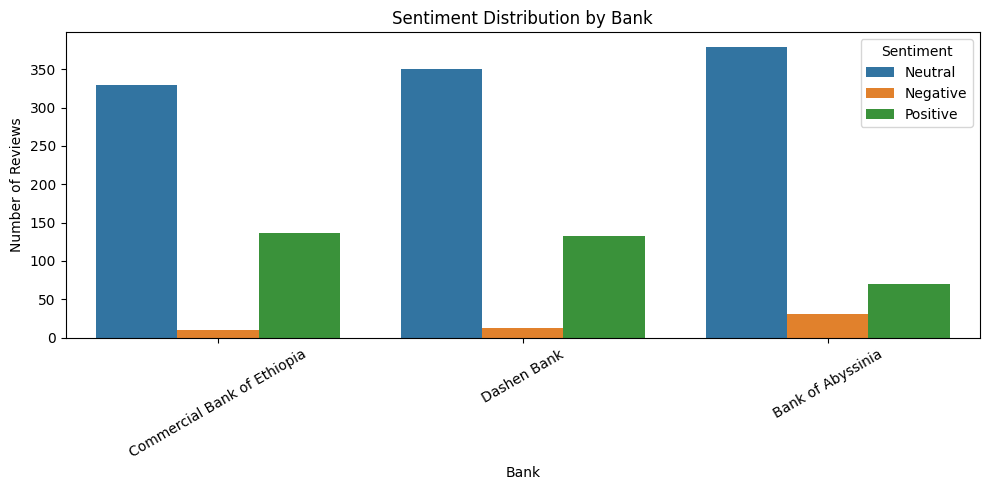

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='bank_name', hue='sentiment_label')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 2. Rating Distribution per Bank (Box Plot)

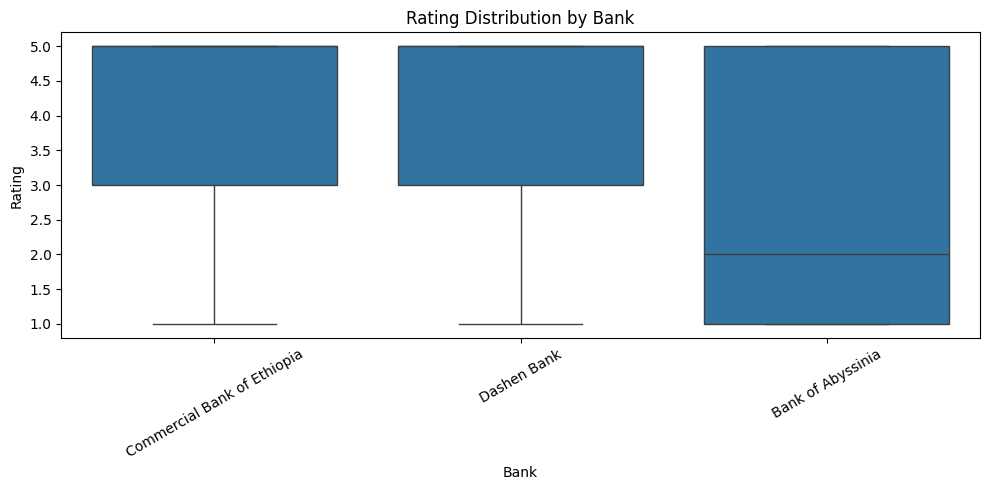

In [47]:
plt.figure(figsize=(10,5))
sns.boxplot(x=data['bank_name'], y=data['rating'])
plt.title("Rating Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Rating")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 3. Sentiment Trend Over Time (Line Chart)

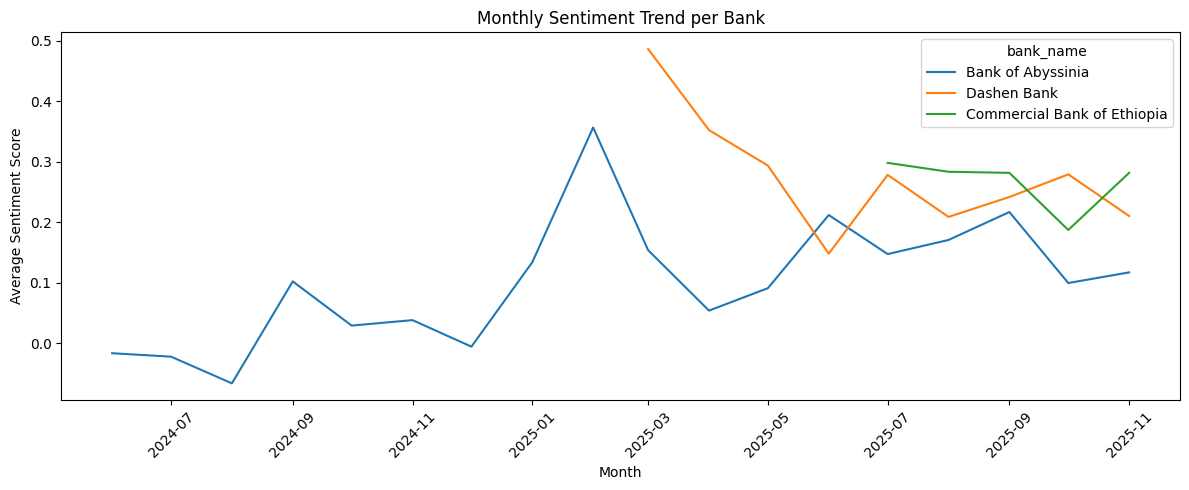

In [48]:
data['review_date'] = pd.to_datetime(data['review_date'])

trend = (
    data.groupby([data['review_date'].dt.to_period('M'), 'bank_name'])['sentiment_score']
      .mean()
      .reset_index()
)

trend['review_date'] = trend['review_date'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=trend, x='review_date', y='sentiment_score', hue='bank_name')
plt.title("Monthly Sentiment Trend per Bank")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Keyword Cloud per Bank (WordCloud)

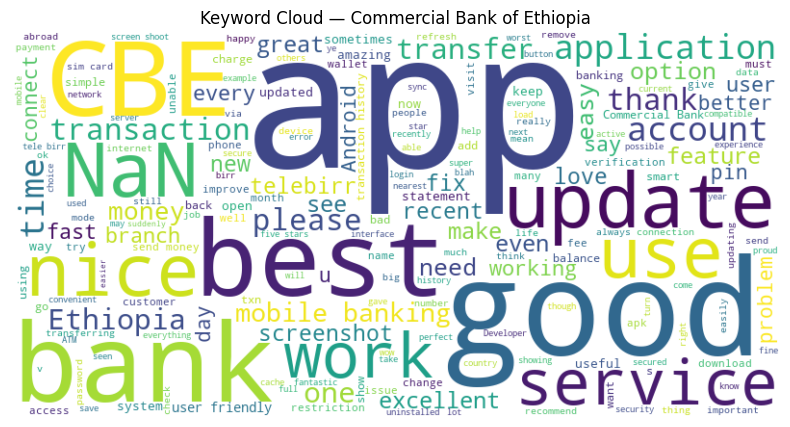

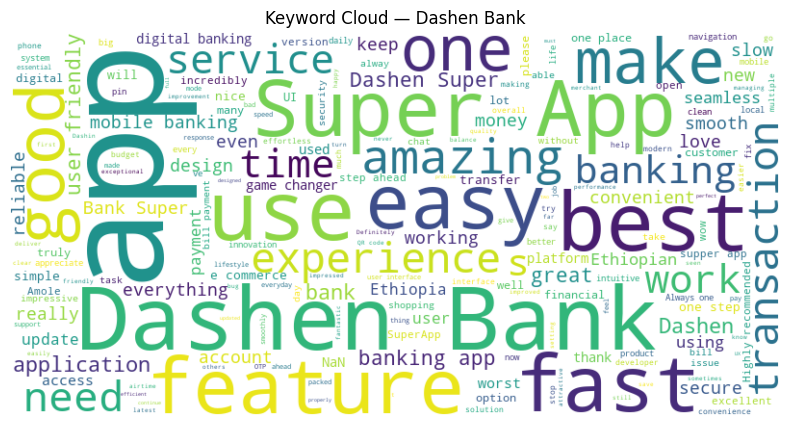

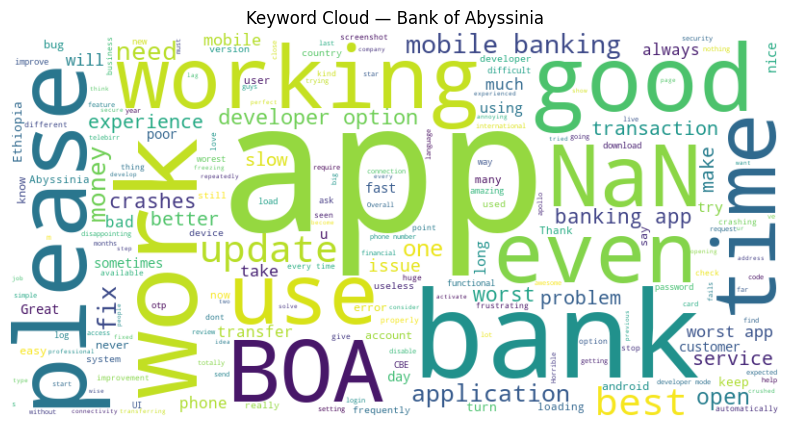

In [49]:


for bank in data['bank_name'].unique():
    text = " ".join(data[data['bank_name'] == bank]['review_text'].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Keyword Cloud — {bank}")
    plt.show()
